In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import resource
import time
from datetime import datetime
import math
import os
from sklearn import preprocessing
import sys
import cvxpy
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool

import keras
from keras.datasets import mnist
from random import randint

2023-03-22 08:37:59.222909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 08:37:59.223219: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


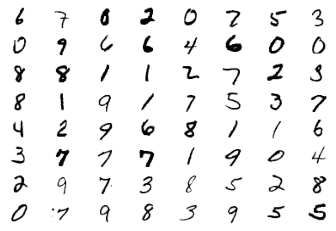

In [2]:
## Preprocessing of data
# Load data here:

# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert class vectors to binary class matrices (One-hot)
# num_classes = 10
# y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

# Show some random digits
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

In [3]:
# #Split dataset to 10 partitions
def split_workers(X_data, y_data, num_worker):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
        
    return data_X_list, data_y_list

x_train_list, y_train_list = split_workers(x_train, y_train, 10)
x_test_list, y_test_list = split_workers(x_test, y_test, 10)

In [4]:
print(y_test_list[1].shape)
print(x_train_list[0].shape)

(1000,)
(6000, 784)


In [5]:
# ------------------------- SVM Classificaton ----------------------------------

#multiclass SVM classification loss and its gradient
def SVM_classify(x, w):
    return np.argmax(np.matmul(x.T, w), axis = 1).reshape(x.shape[1], 1)

def SVM_cost(x, y, w):
    svm_cost = (np.matmul(x.T, w) - np.repeat(np.multiply(x.T, w[:,y.reshape(y.shape[0])].T).sum(axis = 1).reshape(y.shape[0], 1), 10, axis = 1) + delta).clip(min = 0)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] = 0
    return svm_cost

def regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum() + lambda_/2 * np.linalg.norm(w)**2

def SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad_coef = svm_cost
    svm_cost_grad_coef[(range(y.shape[0]), y.reshape(y.shape[0]))] -= svm_cost.sum(axis=1)
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_grad[:, i] = np.multiply(svm_cost_grad_coef[:, i].reshape(svm_cost_grad_coef.shape[0], 1), x.T).sum(axis = 0)
    return svm_cost_grad


#binary SVM classification one-vs-rest loss and its gradient
def bin_SVM_classify(x, w):
    scores = np.matmul(x.T, w)
    class_votes = np.zeros(scores.shape())
    class_votes[scores > 0] += 1
    for i in range(10):
        class_votes[scores[:,i] <= 0,:] += 1
    class_votes[scores <= 0] -= 1
    return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)
            
def bin_SVM_cost(x, y, w):
    svm_cost = - np.matmul(x.T, w)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] *= -1
    return (1 - svm_cost).clip(min = 0)

def bin_regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum(axis = 1) + lambda_/2 * np.linalg.norm(w, axis = 1)**2

def bin_SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_yi = svm_cost[:, i]
        svm_cost_yi[y == i] *= -1
        svm_cost_grad[:, i] = np.multiply(x, svm_cost_yi.T).sum(axis = 0) + lambda_ * w[:, i]
    return svm_cost_grad



#plot loss vs signaling at master node
def plot_master_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 1, len(curves[k]))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        T, loss = zip(*errs)
        plt.plot(T, loss, color = next(colors))
        legends.append(legend)
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    plt.title('Convergence vs signaling (%s)' % k)
    if len(legends) > 1:
        plt.legend(legends)
    plt.show()
    
    
#plot greyscale plots of computed models of each digit
def plot_w_ks(w_k):
    fig, axarr = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        axarr[i / 5, i % 5].imshow(w_k[:28*28,i].reshape(28, 28), cmap='gray', interpolation='none')
        axarr[i / 5, i % 5].set_title("Digit: {}".format(i))
        axarr[i / 5, i % 5].set_xticks([])
        axarr[i / 5, i % 5].set_yticks([])

    plt.show()
    
    
#plot average agent loss vs signaling and the region between min and max loss
def plot_agents_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 1, len(curves[k].keys()))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        color = next(colors)
        T, losses = zip(*errs)
        legends.append(legend)
        losses = zip(*losses)
        mean = np.array(losses).mean(axis = 0)
        lmin = np.array(losses).min(axis = 0)
        lmax = np.array(losses).max(axis = 0)
        var = np.array(losses).var(axis = 0)
        plt.plot(T, mean, color = color)
        plt.fill_between(T, lmin, lmax,facecolor = color, alpha=0.2, edgecolor='none')
        #plt.fill_between(T, mean - var, mean + var,facecolor = color, alpha=0.2, edgecolor='none')
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    if len(legends) > 1:
        plt.legend(legends)
    plt.title('Convergence vs signaling (%s)' % k)
    plt.show()
    
    
    
    
    
    #single agent GD SVM
def gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs 



#single agent binary GD SVM
def bin_gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = np.linalg.norm(bin_regulated_total_cost(x, y, w_k, lambda_))
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = bin_SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = np.linalg.norm(regulated_total_cost(x, y, w_k, lambda_))
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs 

    
    

In [7]:
## CA5---------------------------- Part (a)------------------------------------------------------------------------------

#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data adding noise with probability p :
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    # noise = np.random.binomial(1, p, w_k.shape)
    # x_noise = np.multiply(x, noise)
    # y_noise = np.multiply(y, noise)
    
    ## compute the gradients ----------------------------------------
    # grad_w = SVM_cost_grad(x_noise, y_noise, w_k, lambda_)
    grad_w = SVM_cost_grad(x, y, w_k, lambda_)

    return grad_w


def decentralized_gradient_descent_worker_(args):
    return decentralized_gradient_descent_worker(*args)


#Master updates the gradient w.r.t w_k for each class
def decentralized_gradient_descent_master(w_k, a_k, grad_w, x, y, lambda_):
    ## compute w_k --------------------------------------------------
    for i in range(10):
        w_k -= a_k * grad_w[i]
    return 10, w_k

#DGD
def decentralized_gradient_descent(x, y, workers_x, workers_y, lambda_, a_k, max_iter, master, worker_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    T = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    for k in range(max_iter):
        L = L1
        #copy w_k of classes for workers
        if compress is not None:
            w_k = compress(w_k)
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        
        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_x, workers_y, workers_w_k, 10 * [lambda_])
        
        pool = ThreadPool(10)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        
        ## complete signal, grad_w ---------------------
        signals, grad_w = 10 * len(results), results
        grad_w = np.array(grad_w)
        
        ## calculate T ---------------------------------
        T +=  signals
        if compress is not None:
            for i in range(10):
                grad_w[i] = compress(grad_w[i])
                
        #master updates w_ks
        
        ## complete signal, grad_w ---------------------
        signals, w_k = master(w_k, a_k, grad_w, x, y, lambda_)
        ## calculate T
        T += signals
        
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append((T, L1))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(x.shape[0],10), errs



#---------------------------------------------------Run DGD ------------------------------------------------
p = 0.05 # noise probability
lambda_ = 1e-5
a_k = 1e-3
max_iter = 100

## Complete w_k and errs ---------------------------------------
w_k, errs = decentralized_gradient_descent(x_train, y_train, x_train_list, y_train_list, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_, compress = None)


y_predict =  SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))


y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

# curves['decentralized gradient descent'] = {'no compression':(w_k, errs)}


# # ------------------------------plot greyscale models and master loss for DGD ----------------
# # complete the plot 
# plot_w_ks(curves['decentralized gradient descent']['no compression'][0])

# # ------------------------------------------------------------------------------------------------


In [ ]:
## CA5---------------------------- Part (b)------------------------------------------------------------------------------

# Complete communication graph -----------------------
A = ## output
# ----------------------------------------------------

#agent process for decentralized subgradient method (DSM)

def decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k):
    
# complete the following--------------------------------------   
    bar_w_k = # output 
    grad_w = # output 
    bar_w_k = # output 
    return # output 


def decentralized_subgradient_method_agent_(args):
    return decentralized_subgradient_method_agent(*args)

# complete the following for ADMM --------------------------------------   

A_ADMM = A - #complete it 

#agent process for ADMM
# complete the following--------------------------------------   
def admm_over_network_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = # output 
    grad_w = # output 
    bar_w_k = # output 
    return # output 

def admm_over_network_agent_(args):
    return admm_over_network_agent(*args)


#decentralized optimization over network
def decentralized_method(x, y, workers_x, workers_y, lambda_, a_k, max_iter, A, agent_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(10, x.shape[0], 10)
    T = 0
    errs = []
    ## Calculate L1 ------------------------------------------------
    L1 = # output 
   
    for k in range(max_iter):
        L = L1
        #transmit w_ks and 
        workers_w_k = np.array(10 * [w_k]).reshape(10, 10, x.shape[0], 10)
        if compress is not None:
            compressed_w_k = np.zeros((10, x.shape[0], 10))
            for i in range(10):
                compressed_w_k[i] = compress(w_k[i])
            workers_w_k = np.array(10 * [compressed_w_k]).reshape(10, 10, x.shape[0], 10)
            for i in range(10):
                workers_w_k[i, i] = w_k[i]
        #each agent gets a copy of w_ks of neighbors, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(A, workers_x, workers_y, workers_w_k, 10 * [lambda_], 10 * [a_k])
        
        pool = ThreadPool(10)
        results = pool.map(agent_, zipped)
        pool.close()
        pool.join()
        # Complete signals, w_k, grad_w ------------------------------ 
        signals, w_k, grad_w = #output 
        grad_w = np.array(grad_w)
        w_k = np.array(w_k)
        
         # Complete T ------------------------------------------------
        T += #output 
        
         # Complete L1 ----------------------------------------------
        L1 = #output 
        
        L1s = []
        for i in range(10):
            L1s.append(regulated_total_cost(x, y, w_k[i], lambda_))
        errs.append((T, L1s))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w.mean(axis = 0))))
    return w_k.mean(axis = 0).reshape(x.shape[0],10), errs



# ---------------------------------------- Run DSM ------------------------------------------------------
print(datetime.now())

 # complete w_k, errs -------------------------
w_k, errs = #output 
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method'] = {'no compression':(w_k, errs)}

# ------------------------------------------Run ADMM ----------------------------------------------------
print(datetime.now())
# complete w_k, errs -------------------------
w_k, errs = #output 
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training accuracy: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test accuracy: %.3f" % nmae(y_test, y_predict))


curves['ADMM over network'] = {'no compression':(w_k, errs)}


#plot greyscale models and average agent loss for DSM
plot_w_ks(curves['decentralized subgradient method']['no compression'][0])

plot_agents_loss('decentralized subgradient method')




# ------------------------------plot greyscale models and average agent loss for ADMM -----------------------


# complete the plot 





In [ ]:
## CA5---------------------------- Part (c)------------------------------------------------------------------------------

# Propose your approach here -----------------------

Proposal 1: Reduce the dimensionality through RBF kernel
Pro: shorter computational time and thus shorter T
Con: accuracy may be affected negatively

Proposal 2: use SGD instead
Pro: simpler computation and thus shorter T, provided the dataset is large and dense such that SVM would require much higher computational time.
Con: require more hyperparameter tuning and requires finding the solution through several iterations. 